# Test des modeles de segmentation et classification sur le nouveau dataset
Au prealable, on a selectionne 723 images non redondantes avec le dataset initial depuis le jeu de donnees COVIDNET
On conserve les sources actmed, fig1, cohen


In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
%matplotlib inline
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [2]:
# Import des donnees 

path = r"C:\Users\Inrae\Documents\Projet_Data_Science\COVID_NET\SELECT"
dim=256
final_size=(dim, dim)

# Import des données on sépare entre apprentissage et validation
batch_size=32
size=final_size

# Nombre de donnes max par categorie
size_max_cat = None



## Import des fichiers

In [3]:
def getData(X_shape, N = None):
    im_array = []
    target_array = []

    for cat in ["Normal", "COVID"]:       
        image_path = os.path.join(path,cat)
        target = cat
        files = os.listdir(image_path)
        random.Random(1337).shuffle(files)
        
        if (N is None):
            N = len(files)
        else:
            N = min(N, len(files))
        for i in files[:N]: 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            target=cat
            im_array.append(im)
            target_array.append(target)
            
    images = np.array(im_array).reshape(len(im_array),dim,dim,1)
    return images, target_array

# Creation du masque

# dataset = tf.keras.utils.image_dataset_from_directory(rescale=1./255, 
#     path,
#     image_size=final_size,
#     batch_size=batch_size)

In [4]:
# Importing data
dim = 256
images, labels = getData(dim,N=size_max_cat)

print("dataset size : images", images.shape, "labels", len(labels))


dataset size : images (723, 256, 256, 1) labels 723


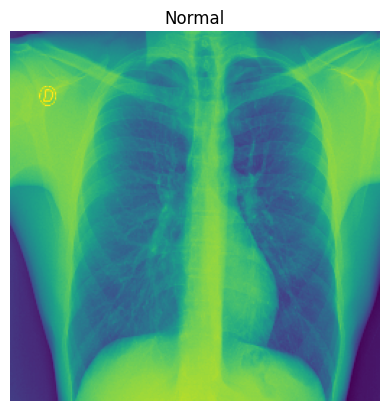

In [5]:
i=3

plt.imshow(images[3])
plt.axis("off")
plt.title(labels[3])
plt.show()

## Segmentation : Génération des masques

In [6]:
# Fonction pour definir le modele

def unet(input_size=(dim,dim,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])




In [107]:
# Creation du modele et import des poids
model = unet(input_size=(256,256,1))
model.load_weights("cxr_reg_weights.best.hdf5")
model.compile(optimizer='adam', loss='binary_crossentropy')

In [129]:
# Mise en forme des images

images_scaled = (images-127)/127

print("Shape de image_scaled: ", images_scaled.shape)

# On fait un data_generator

datagen = ImageDataGenerator() 

# Augmenter respectivement les jeu de données d'entrainement
dataset = datagen.flow(images_scaled, labels, batch_size = 8)

# On predit sur dataset
masks = model.predict(dataset)

# Convertir le masque avec np.argmax pour obtenir des valeurs 0 et 1
mask2 = np.argmax(masks)

# Multiplier par 255 pour convertir les valeurs 0 et 1 en 0 et 255
mask2_255 = mask2 * 255

print("Shape de masks : ", masks.shape)


Shape de image_scaled:  (723, 256, 256, 1)
Shape de masks :  (723, 256, 256, 1)


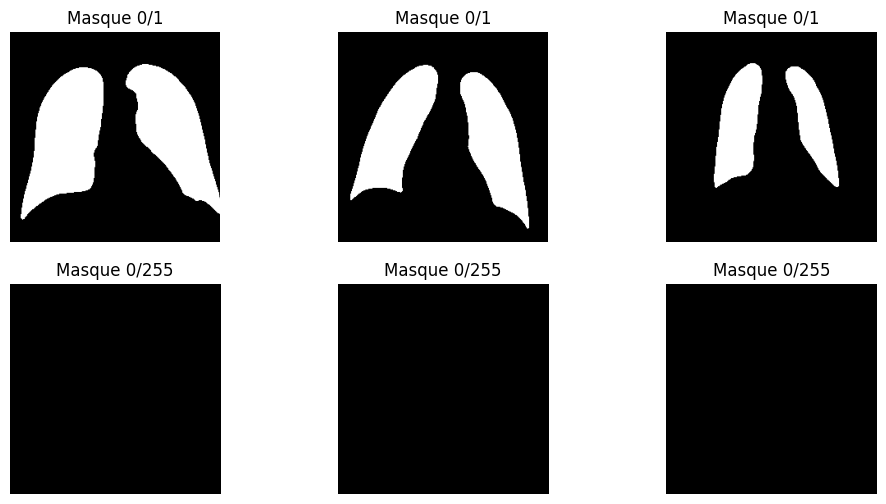

In [132]:
import matplotlib.pyplot as plt
import numpy as np

# Supposons que masks est le résultat de la prédiction du modèle
masks = model.predict(dataset)

# Convertir le masque avec np.argmax pour obtenir des valeurs 0 et 1
mask2 = np.argmax(masks, axis=-1)

# Multiplier par 255 pour convertir les valeurs 0 et 1 en 0 et 255
mask2_255 = mask2 * 255

# Afficher le masque original et le masque converti
plt.figure(figsize=(12, 6))
for i in range(3):  # Afficher les trois premiers masques pour exemple
    plt.subplot(2, 3, i + 1)
    plt.imshow(masks[i], cmap='gray')
    plt.title('Masque 0/1')
    plt.axis('off')
    
    plt.subplot(2, 3, i + 4)
    plt.imshow(mask2[i], cmap='gray')
    plt.title('Masque 0/255')
    plt.axis('off')

plt.show()


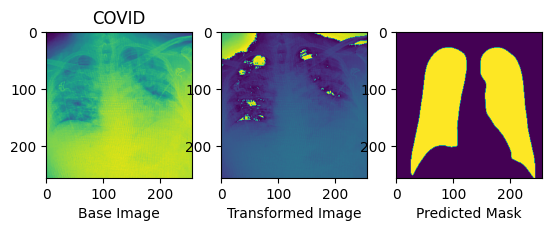

In [128]:
for i in range(0,3,6):
    j = random.randint(0, len(labels))
    plt.subplot(2,3,i+1)
    plt.imshow(images[j])
    plt.xlabel("Base Image")
    plt.title(labels[j])
    
    plt.subplot(2,3,i+2)
    plt.imshow(images_scaled[j])
    plt.xlabel("Transformed Image")

    plt.subplot(2,3,i+3)
    plt.imshow(masks[j])
    plt.xlabel("Predicted Mask")



# Application du modèle de classification

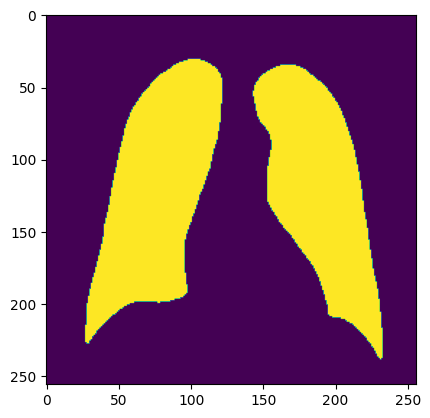

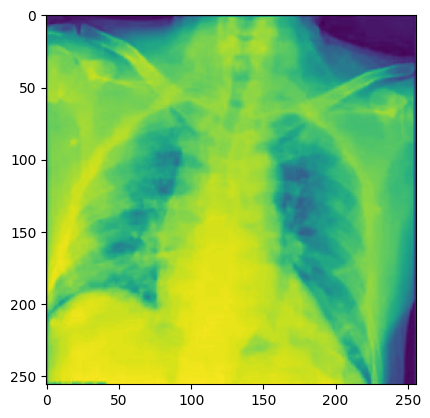

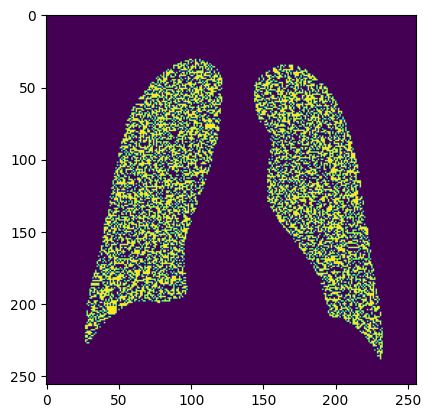

In [105]:
# Preparation des donnees, on masque les images
masked_image_array=[]

for i in range(images.shape[0]) : 
    img = images[i]
    msk = masks[i].astype(img.dtype)
    masked_image = cv2.bitwise_and(img, msk)
    #masked_image = cv2.resize(masked_image, dsize = (224, 224))
    #masked_image_array.append(masked_image)

#masked_images = np.array(masked_image_array).reshape(len(masked_image_array),224,224,1)
#masked_images.shape

plt.imshow(msk)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(masked_image)

In [86]:
# On prepare le datagenerator

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

clf_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    ) 

clf_dataset = clf_datagen.flow(masked_images, batch_size = 8)


In [89]:
# On charge le modele

clf_model = model = tf.keras.models.load_model("../models/model_resnet50_CHO_v1")


In [90]:
# On fait les predictions

labels_pred = clf_model.predict(clf_dataset)

IndexError: index 1 is out of bounds for axis 2 with size 1